In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (LSTM, Dense, Concatenate, Attention, Dropout, Softmax,
                                     Input, Flatten, Activation, Bidirectional, Permute, multiply, 
                                     ConvLSTM2D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D)

from scipy import stats

os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(1)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

2023-10-29 05:18:02.320984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 05:18:02.361952: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 05:18:02.361987: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 05:18:02.362013: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 05:18:02.368887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 05:18:02.369352: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

keyponts

In [2]:

mp_pose = mp.solutions.pose

mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    """
    This function detects human pose estimation keypoints from webcam footage
    
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                 
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [4]:
def draw_landmarks(image, results):
    """
    This function draws keypoints and landmarks detected by the human pose estimation model
    
    """
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )

In [5]:
cap = cv2.VideoCapture(3) 
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
FPS = int(cap.get(cv2.CAP_PROP_FPS)) 
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        ret, frame = cap.read()
      
        image, results = mediapipe_detection(frame, pose)
        
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass
        
        draw_landmarks(image, results)               
        
        cv2.imshow('OpenCV Feed', image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


GET

In [6]:

pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [7]:
num_landmarks = len(landmarks)
num_values = len(test)
num_input_values = num_landmarks*num_values

In [8]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

In [9]:
def extract_keypoints(results):
    """
    Processes and organizes the keypoints detected from the pose estimation model 
    to be used as inputs for the exercise decoder models
    
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

data folder

In [10]:
DATA_PATH = os.path.join(os. getcwd(),'data') 
print(DATA_PATH)

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

actions = np.array(['curl', 'press', 'squat'])
num_classes = len(actions)

no_sequences = 50

sequence_length = FPS*1

start_folder = 101

/home/cyclops/Desktop/datahon/streamlitfrommain/data


In [11]:

for action in actions:     
    for sequence in range(start_folder,no_sequences+start_folder):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))  
        except:
            pass

colour inputs

In [12]:

colors = [(245,117,16), (117,245,16), (16,117,245)]

In [13]:
cap = cv2.VideoCapture(3)
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    for idx, action in enumerate(actions):
        for sequence in range(start_folder, start_folder+no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, pose)
                try:
                    landmarks = results.pose_landmarks.landmark
                except:
                    pass
                draw_landmarks(image, results) 
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

In [14]:
cap.release()
cv2.destroyAllWindows()

heatlabel map

In [15]:
label_map = {label:num for num, label in enumerate(actions)}

In [16]:

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):         
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)  
            
        sequences.append(window)
        labels.append(label_map[action])

In [17]:

X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(X.shape, y.shape)

(150, 30, 132) (150, 3)


In [18]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
print(X_train.shape, y_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, random_state=2)

(135, 30, 132) (135, 3)


start nerual train

In [28]:
 
es_callback = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=10, verbose=0, mode='min')
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=0, mode='min')
chkpt_callback = ModelCheckpoint(filepath=DATA_PATH, monitor='val_loss', verbose=0, save_best_only=True, 
                                 save_weights_only=False, mode='min', save_freq=1)

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

batch_size = 32
max_epochs = 500

LSTM
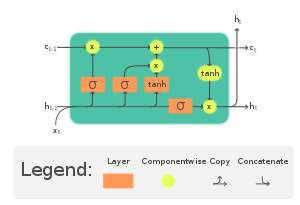

In [29]:
NAME = f"ExerciseRecognition-LSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [30]:
lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(sequence_length, num_input_values)))
lstm.add(LSTM(256, return_sequences=True, activation='relu'))
lstm.add(LSTM(128, return_sequences=False, activation='relu'))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(actions.shape[0], activation='softmax'))
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 128)           133632    
                                                                 
 lstm_5 (LSTM)               (None, 30, 256)           394240    
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 749955 (2.86 MB)
Trainable params: 74995

In [31]:
lstm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
lstm.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500
4/4 [==============================] - 5s 244ms/step - loss: 57883.5977 - categorical_accuracy: 0.3393 - val_loss: 212370.3438 - val_categorical_accuracy: 0.2609 - lr: 0.0100
Epoch 2/500
4/4 [==============================] - 0s 61ms/step - loss: 226033.2344 - categorical_accuracy: 0.3750 - val_loss: 106062.1094 - val_categorical_accuracy: 0.3913 - lr: 0.0100
Epoch 3/500
4/4 [==============================] - 0s 62ms/step - loss: 53097.5039 - categorical_accuracy: 0.3304 - val_loss: 2056.9082 - val_categorical_accuracy: 0.3478 - lr: 0.0100
Epoch 4/500
4/4 [==============================] - 0s 66ms/step - loss: 3061.5598 - categorical_accuracy: 0.2500 - val_loss: 4615.7871 - val_categorical_accuracy: 0.2609 - lr: 0.0100
Epoch 5/500
4/4 [==============================] - 0s 63ms/step - loss: 7236.2319 - categorical_accuracy: 0.3750 - val_loss: 31486.8262 - val_categorical_accuracy: 0.3478 - lr: 0.0100
Epoch 6/500
4/4 [==============================] - 0s 62ms/step - loss: 276

ADD ATTENTION
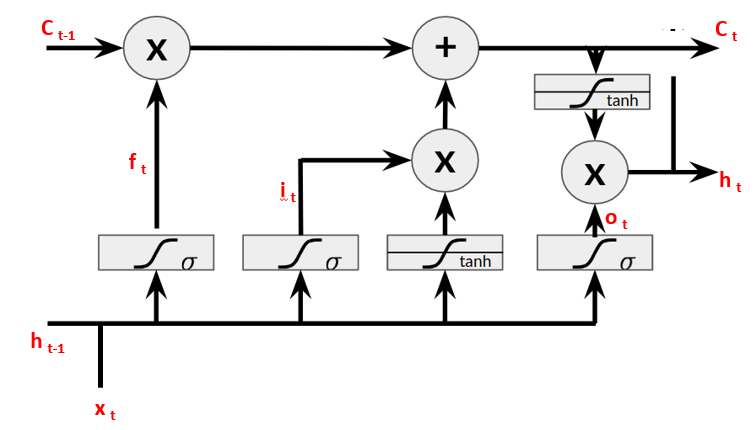

In [32]:
NAME = f"ExerciseRecognition-AttnLSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [33]:
def attention_block(inputs, time_steps):
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul') 
    return output_attention_mul

In [34]:
HIDDEN_UNITS = 256

# Input
inputs = Input(shape=(sequence_length, num_input_values))

# Bi-LSTM
lstm_out = Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True))(inputs)

# Attention
attention_mul = attention_block(lstm_out, sequence_length)
attention_mul = Flatten()(attention_mul)

# Fully Connected Layer
x = Dense(2*HIDDEN_UNITS, activation='relu')(attention_mul)
x = Dropout(0.5)(x)

# Output
x = Dense(actions.shape[0], activation='softmax')(x)

# Bring it all together
AttnLSTM = Model(inputs=[inputs], outputs=x)
print(AttnLSTM.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 132)]            0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 30, 512)              796672    ['input_2[0][0]']             
 onal)                                                                                            
                                                                                                  
 permute_1 (Permute)         (None, 512, 30)              0         ['bidirectional_1[0][0]']     
                                                                                                  
 dense_9 (Dense)             (None, 512, 30)              930       ['permute_1[0][0]']     

In [35]:
AttnLSTM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
AttnLSTM.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500
4/4 [==============================] - 6s 393ms/step - loss: 1.0900 - categorical_accuracy: 0.4196 - val_loss: 1.0659 - val_categorical_accuracy: 0.8261 - lr: 8.0000e-05
Epoch 2/500
4/4 [==============================] - 0s 85ms/step - loss: 1.0376 - categorical_accuracy: 0.8482 - val_loss: 1.0050 - val_categorical_accuracy: 0.7826 - lr: 8.0000e-05
Epoch 3/500
4/4 [==============================] - 0s 86ms/step - loss: 0.9553 - categorical_accuracy: 0.8750 - val_loss: 0.9164 - val_categorical_accuracy: 0.7826 - lr: 8.0000e-05
Epoch 4/500
4/4 [==============================] - 0s 87ms/step - loss: 0.8219 - categorical_accuracy: 0.9196 - val_loss: 0.7670 - val_categorical_accuracy: 0.8261 - lr: 8.0000e-05
Epoch 5/500
4/4 [==============================] - 0s 87ms/step - loss: 0.6683 - categorical_accuracy: 0.8393 - val_loss: 0.6499 - val_categorical_accuracy: 0.7826 - lr: 8.0000e-05
Epoch 6/500
4/4 [==============================] - 0s 93ms/step - loss: 0.4923 - categorical_a

In [36]:

models = {
    'LSTM': lstm, 
    'LSTM_Attention_128HUs': AttnLSTM, 
}

save weight

In [37]:
for model_name, model in models.items():
    save_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.save(save_dir)

/home/cyclops/Desktop/datahon/env/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


load

In [38]:
# for some reason youtube said to this 
for model_name, model in models.items():
    load_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.load_weights(load_dir)

make prediction test

In [39]:
for model in models.values():
    res = model.predict(X_test, verbose=0)   

confusion mattrix ++ accuracy
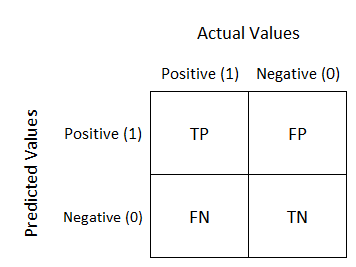

In [40]:
eval_results = {}
eval_results['confusion matrix'] = None
eval_results['accuracy'] = None
eval_results['precision'] = None
eval_results['recall'] = None
eval_results['f1 score'] = None

confusion_matrices = {}
classification_accuracies = {}   
precisions = {}
recalls = {}
f1_scores = {} 

full confusion matrix 
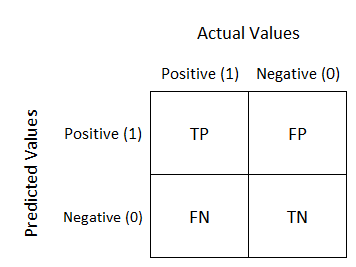

In [41]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    confusion_matrices[model_name] = multilabel_confusion_matrix(ytrue, yhat)
    print(f"{model_name} confusion matrix: {os.linesep}{confusion_matrices[model_name]}")

eval_results['confusion matrix'] = confusion_matrices

LSTM confusion matrix: 
[[[ 0 10]
  [ 0  5]]

 [[ 9  0]
  [ 6  0]]

 [[11  0]
  [ 4  0]]]
LSTM_Attention_128HUs confusion matrix: 
[[[10  0]
  [ 0  5]]

 [[ 9  0]
  [ 1  5]]

 [[10  1]
  [ 0  4]]]


accuracy

In [42]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    classification_accuracies[model_name] = accuracy_score(ytrue, yhat)    
    print(f"{model_name} classification accuracy = {round(classification_accuracies[model_name]*100,3)}%")

eval_results['accuracy'] = classification_accuracies

LSTM classification accuracy = 33.333%
LSTM_Attention_128HUs classification accuracy = 93.333%


In [43]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    report = classification_report(ytrue, yhat, target_names=actions, output_dict=True)
    
    precisions[model_name] = report['weighted avg']['precision']
    recalls[model_name] = report['weighted avg']['recall']
    f1_scores[model_name] = report['weighted avg']['f1-score'] 
   
    print(f"{model_name} weighted average precision = {round(precisions[model_name],3)}")
    print(f"{model_name} weighted average recall = {round(recalls[model_name],3)}")
    print(f"{model_name} weighted average f1-score = {round(f1_scores[model_name],3)}\n")

eval_results['precision'] = precisions
eval_results['recall'] = recalls
eval_results['f1 score'] = f1_scores

LSTM weighted average precision = 0.111
LSTM weighted average recall = 0.333
LSTM weighted average f1-score = 0.167

LSTM_Attention_128HUs weighted average precision = 0.947
LSTM_Attention_128HUs weighted average recall = 0.933
LSTM_Attention_128HUs weighted average f1-score = 0.934



/home/cyclops/Desktop/datahon/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyclops/Desktop/datahon/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyclops/Desktop/datahon/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu